In [1]:
#Basic Python and Machine learning libraries
import os, sys, warnings, random, time, cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import skimage.io
from PIL import Image
from scipy import stats
from sklearn import metrics
from sklearn.model_selection import StratifiedKFold
from IPython.display import display
from tqdm import tqdm_notebook as tqdm

#Pytorch and Albumentations(Data Augmentation Library)
import torch
import albumentations
from albumentations.pytorch import ToTensorV2
from torch import nn, optim
from torch.optim.lr_scheduler import ReduceLROnPlateau, CosineAnnealingLR, CosineAnnealingWarmRestarts
from torch.functional import F 
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models

#A piece of code that will allow me to use and retrain Efficient Nets from my input folder
package_path = '../input/efficientnet-pytorch/EfficientNet-PyTorch/EfficientNet-PyTorch-master'
lr_path = '../input/gradual-warmup-lr/pytorch-gradual-warmup-lr-master'
sys.path.append(package_path)
sys.path.append(lr_path)
from efficientnet_pytorch import model as enet
from warmup_scheduler import GradualWarmupScheduler

#Mandatory Lines of code when working with jupyter notebooks
%matplotlib inline
warnings.filterwarnings('ignore')

In [2]:
# I Just wanted my plots to look neat hence fixing some plot styles
plt.style.use('seaborn-whitegrid')
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['font.sans-serif'] = 'Arial'
plt.rcParams['text.color'] = 'black'
plt.rcParams['axes.labelcolor']= 'black'
plt.rcParams['xtick.color'] = 'black'
plt.rcParams['ytick.color'] = 'black'
plt.rcParams['font.size'] = 12

In [3]:
class Config:
    
    DEBUG = False
    tqdm_bar = False
    pwd = '/kaggle/working/'
    data_dir = '../input/prostate-cancer-grade-assessment/'
    train_img_dir = os.path.join(data_dir, 'train_images')
    test_img_dir = os.path.join(data_dir, 'test_images')
    num_images_to_plot = 16
    num_folds = 2 if DEBUG else 5
    height = 512
    width = 512
    out_dim = 5
    batch_size = 16
    num_workers = 4
    num_epochs = 2 if DEBUG else 10
    num_warmup_epochs = 1
    warmup_factor = 10
    SEED = 713
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    #Image-net standard mean and std
    mean = [0, 0, 0]
    std = [255, 255, 255]
    pretrainied_models = {
        'efficientnet-b0': '../input/efficientnet-pytorch/efficientnet-b0-08094119.pth'
    }

In [4]:
# Fixing seed so that our results are always reproducible
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(Config.SEED)

In [5]:
train_df = pd.read_csv(Config.data_dir+'train.csv')
train_df = train_df.sample(100).reset_index(drop=True) if Config.DEBUG else train_df
display(train_df.head())
len(train_df)

,image_id,data_provider,isup_grade,gleason_score
0,0005f7aaab2800f6170c399693a96917,karolinska,0,0+0
1,000920ad0b612851f8e01bcc880d9b3d,karolinska,0,0+0
2,0018ae58b01bdadc8e347995b69f99aa,radboud,4,4+4
3,001c62abd11fa4b57bf7a6c603a11bb9,karolinska,4,4+4
4,001d865e65ef5d2579c190a0e0350d8f,karolinska,0,0+0


10616

In [6]:
def tile(img, sz=128, N=16, tile_transforms=None):
    shape = img.shape
    pad0,pad1 = (sz - shape[0]%sz)%sz, (sz - shape[1]%sz)%sz
    img = np.pad(img,[[pad0//2,pad0-pad0//2],[pad1//2,pad1-pad1//2],[0,0]],
                 constant_values=255)
    img = img.reshape(img.shape[0]//sz,sz,img.shape[1]//sz,sz,3)
    img = img.transpose(0,2,1,3,4).reshape(-1,sz,sz,3)
    if len(img) < N:
        img = np.pad(img,[[0,N-len(img)],[0,0],[0,0],[0,0]],constant_values=255)
    idxs = np.argsort(img.reshape(img.shape[0],-1).sum(-1))[:N]
    img = img[idxs]
    if tile_transforms is not None:
        for i in range(N):
            augmented = tile_transforms(image=img[i])
            img[i] = augmented["image"]
            
    return img

In [7]:
class Build_Dataset(Dataset):
    '''Builds Dataset to be fed to Neural Network
       :param df: train_df or test_df
       :param resize: tuple, eg(256, 256)
       :param mode: string train or test 
       :param: augmentations: Image augmentations
    '''
    #Here I am defining my constructor
    def __init__(self, df, resize=None, mode='train', augmentations=None, tile_transforms=None):
        self.df = df
        self.resize = resize
        self.mode = mode
        self.augmentations = augmentations
        self.tile_transforms = tile_transforms
      
    # This method returns the total length of the dataset
    def __len__(self):
        return len(self.df)
    
    # This method returns (image, label) at index idx
    def __getitem__(self, idx):
        if self.mode == 'train':
            img_path = os.path.join(Config.train_img_dir, self.df['image_id'].values[idx]) + '.tiff'
            image = skimage.io.MultiImage(img_path)[1]
            image = tile(image, sz=128, N=16, tile_transforms=self.tile_transforms)
            isup_grade = self.df['isup_grade'].values[idx]
            
        if self.mode == 'test':
            img_path = os.path.join(Config.test_img_dir, self.df['image_id'].values[idx]) + '.tiff'
            image = skimage.io.MultiImage(img_path)[1]
            image = tile(image, sz=256, N=16, tile_transforms=self.tile_transforms)
            isup_grade = -1
            
        images = []
        for i in range(4):
            images.append(cv2.vconcat([image[i*4+j] for j in range(4)]))
                
        image = cv2.hconcat(images)
        label = np.zeros(5, dtype=np.float32)
        label[:isup_grade] = 1
        if self.resize is not None:
            image = cv2.resize(image, (self.resize[0], self.resize[1]))
            
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = np.array(image)
        image = 255-image
        if self.augmentations is not None:
            augmented = self.augmentations(image=image)
            image = augmented["image"]
            
        return image, label
            

In [8]:
# The below code will plot down some images for you, given a list of images
def plot_images(images):

    n_images = len(images)

    rows = int(np.sqrt(n_images))
    cols = int(np.sqrt(n_images))

    fig = plt.figure(figsize=(20,10))
    for i in range(rows*cols):
        ax = fig.add_subplot(rows, cols, i+1)
        ax.set_title('ISUP: '+str(images[i][1]))
        ax.imshow(np.array(images[i][0]))
        ax.axis('off')

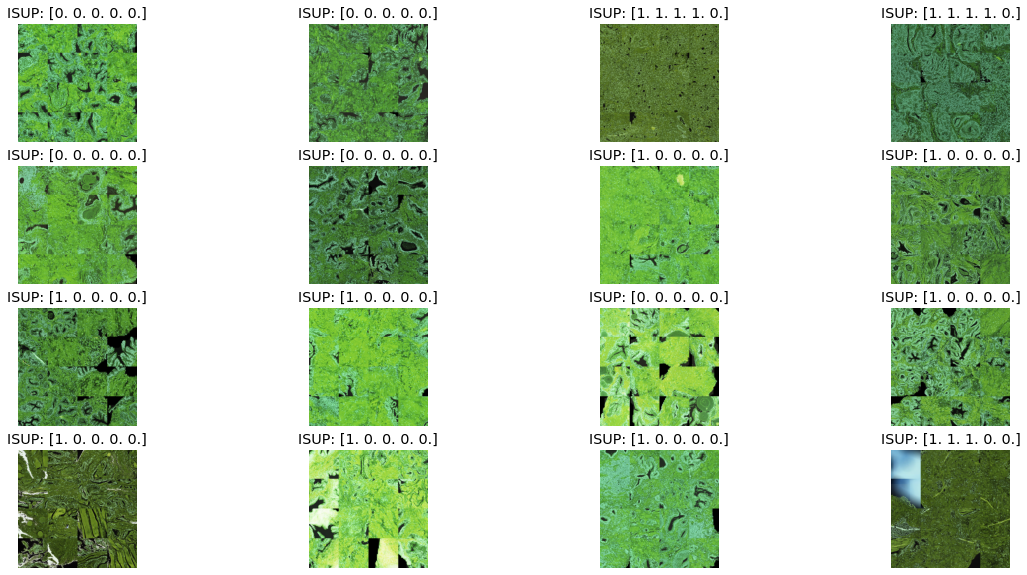

In [9]:
tile_transforms = train_transforms = albumentations.Compose([
    albumentations.HorizontalFlip(p=0.5),
    albumentations.VerticalFlip(p=0.5),
])
train_data = Build_Dataset(train_df, mode='train', tile_transforms=tile_transforms)
images = [(image, label) for image, label in [train_data[i] for i in range(Config.num_images_to_plot)]] 
plot_images(images)
# train_data[0][0].shape

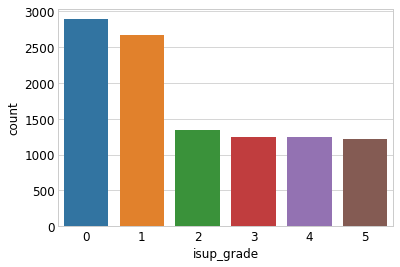

In [10]:
sns.countplot(train_df.isup_grade)

In [11]:
skf = StratifiedKFold(Config.num_folds, shuffle=True, random_state=Config.SEED)
train_df['fold'] = -1
for i, (tr_idx, val_idx) in enumerate(skf.split(train_df, train_df['isup_grade'])):
    train_df.loc[val_idx, 'fold'] = i
train_df.head()

,image_id,data_provider,isup_grade,gleason_score,fold
0,0005f7aaab2800f6170c399693a96917,karolinska,0,0+0,4
1,000920ad0b612851f8e01bcc880d9b3d,karolinska,0,0+0,1
2,0018ae58b01bdadc8e347995b69f99aa,radboud,4,4+4,0
3,001c62abd11fa4b57bf7a6c603a11bb9,karolinska,4,4+4,0
4,001d865e65ef5d2579c190a0e0350d8f,karolinska,0,0+0,2


In [12]:
train_df.drop(columns=['data_provider', 'gleason_score'], inplace=True)
train_df.head()

,image_id,isup_grade,fold
0,0005f7aaab2800f6170c399693a96917,0,4
1,000920ad0b612851f8e01bcc880d9b3d,0,1
2,0018ae58b01bdadc8e347995b69f99aa,4,0
3,001c62abd11fa4b57bf7a6c603a11bb9,4,0
4,001d865e65ef5d2579c190a0e0350d8f,0,2


In [13]:
#Defining train and test transforms
train_transforms = albumentations.Compose([
    albumentations.HorizontalFlip(p=0.5),
    albumentations.VerticalFlip(p=0.5),
    albumentations.Normalize(mean=Config.mean, std=Config.std, always_apply=True),
    albumentations.pytorch.ToTensorV2(),
])
test_transforms = albumentations.Compose([
    albumentations.Normalize(mean=Config.mean, std=Config.std, always_apply=True),
    ToTensorV2(),
])

In [14]:
class enetv2(nn.Module):
    def __init__(self, backbone, out_dim):
        super(enetv2, self).__init__()
        self.enet = enet.EfficientNet.from_name(backbone)
        self.enet.load_state_dict(torch.load(Config.pretrainied_models[backbone]))
        self.myfc = nn.Linear(self.enet._fc.in_features, out_dim)
        self.enet._fc = nn.Identity()
    
    def extract(self, x):
        return self.enet(x)
    
    def forward(self, x):
        x = self.extract(x)
        x = self.myfc(x)
        return x

In [15]:
#These are just 2 helpful functions I like using
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

model = enetv2('efficientnet-b0', Config.out_dim).to(Config.device)
print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 4,013,953 trainable parameters


In [16]:
def train(model, iterator, optimizer, criterion, device):
    
    epoch_loss = 0
    model.train()
    bar = tqdm(iterator) if Config.tqdm_bar else iterator
    
    for (x, y) in bar:
        
        x = x.to(device, dtype=torch.float)
        y = y.to(device, dtype=torch.float)
        optimizer.zero_grad()
        y_pred = model(x)
        loss = criterion(y_pred, y)
        loss.backward()
        optimizer.step()
        loss_np = loss.detach().cpu().numpy()
        epoch_loss += loss_np
        
        if Config.tqdm_bar:
            bar.set_description('Training loss: %.5f' % (loss_np))
        
    return epoch_loss/len(iterator)

def evaluate(model, iterator, scheduler, criterion, device):

    model.eval()
    val_loss = []
    LOGITS = []
    PREDS = []
    TARGETS = []
    bar = tqdm(iterator) if Config.tqdm_bar else iterator

    with torch.no_grad():
        for (x, y) in bar:
            x = x.to(device, dtype=torch.float)
            y = y.to(device, dtype=torch.float)
            logits = model(x)

            loss = criterion(logits, y)

            pred = logits.sigmoid().sum(1).detach().round()
            LOGITS.append(logits)
            PREDS.append(pred)
            TARGETS.append(y.sum(1))

            val_loss.append(loss.detach().cpu().numpy())
            if Config.tqdm_bar:
                bar.set_description('Validation loss: %.5f' % (loss))
                
        val_loss = np.mean(val_loss)

    LOGITS = torch.cat(LOGITS).cpu().numpy()
    PREDS = torch.cat(PREDS).cpu().numpy()
    TARGETS = torch.cat(TARGETS).cpu().numpy()
    
    qwk = metrics.cohen_kappa_score(PREDS, TARGETS, weights='quadratic')
    scheduler.step(val_loss)
#     qwk_k = cohen_kappa_score(PREDS[df_valid['data_provider'] == 'karolinska'], df_valid[df_valid['data_provider'] == 'karolinska'].isup_grade.values, weights='quadratic')
#     qwk_r = cohen_kappa_score(PREDS[df_valid['data_provider'] == 'radboud'], df_valid[df_valid['data_provider'] == 'radboud'].isup_grade.values, weights='quadratic')
#     print('qwk', qwk, 'qwk_k', qwk_k, 'qwk_r', qwk_r)

    return val_loss, qwk

In [17]:
def fit_model(model, model_name, train_iterator, valid_iterator, optimizer, scheduler, loss_criterion, device, num_epochs, fold):
    """ Fits a dataset to model"""
    #Setting best validation loss to infinity :p
    best_valid_metric_score = -1*float('inf')
    
    train_losses = []
    valid_losses = []
    valid_metric_scores = []
    
    #Let's loop through our data
    for epoch in range(num_epochs):
    
        start_time = time.time()
    
        train_loss = train(model, train_iterator, optimizer, loss_criterion, device)
        valid_loss, valid_metric_score = evaluate(model, valid_iterator, scheduler, loss_criterion, device)
        
        train_losses.append(train_loss)
        valid_losses.append(valid_loss)
        valid_metric_scores.append(valid_metric_score)

        #Let's keep updating our model, so that we save only the best one at the end
        if valid_metric_score > best_valid_metric_score:
            best_valid_metric_score = valid_metric_score
            torch.save(model.state_dict(), f'{model_name}_fold_{fold}.pt')
    
        end_time = time.time()

        epoch_mins, epoch_secs = epoch_time(start_time, end_time)
        
        #Printing and returning some important statistics
        print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
        print(f'\tTrain Loss: {train_loss:.3f}')
        print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Metric Score: {valid_metric_score:.3f}')
        
    return pd.DataFrame({f'{model_name}_fold_{fold}_Training_Loss':train_losses,  
                        f'{model_name}_fold_{fold}_Validation_Loss':valid_losses, 
                        f'{model_name}_fold_{fold}_Valid_Metric_Score':valid_metric_scores})

In [18]:
complete_statistics = pd.DataFrame()

for fold in range(1):
    print(f"Fitting on Fold {fold}")
    #Make Train and Valid DataFrame from fold
    train_df_fold = train_df[train_df['fold'] != fold]
    valid_df_fold = train_df[train_df['fold'] == fold]
    
    #Build and load Dataset
    train_data = Build_Dataset(train_df_fold, mode='train', augmentations=train_transforms)
    valid_data = Build_Dataset(valid_df_fold, mode='train', augmentations=test_transforms)
    train_iterator = DataLoader(train_data, shuffle=True, batch_size=Config.batch_size, num_workers=Config.num_workers)
    valid_iterator = DataLoader(valid_data, batch_size=Config.batch_size, num_workers=Config.num_workers)
    
    #Initialize model, loss and optimizer
    model = enetv2('efficientnet-b0', out_dim=Config.out_dim).to(Config.device)
    loss_criterion = nn.BCEWithLogitsLoss().to(Config.device)
    optimizer=optim.Adam(model.parameters(), lr=1e-4/Config.warmup_factor, betas=(0.9, 0.999))
    scheduler_cosine = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, Config.num_epochs-Config.num_warmup_epochs)
    scheduler = GradualWarmupScheduler(optimizer, multiplier=Config.warmup_factor, total_epoch=Config.num_warmup_epochs, after_scheduler=scheduler_cosine)
    
    #Fit the model and visualize the training curves
    train_stats = fit_model(model, 'efficientnet-b0', train_iterator, valid_iterator, optimizer,
                            scheduler, loss_criterion, Config.device, Config.num_epochs, fold)
    complete_statistics = pd.concat([complete_statistics, train_stats], axis=1)
    
    #Just making sure that the output looks neat
    print('\n')
    print('-------------------------------------------------------')
    print('\n')

Fitting on Fold 0
Epoch: 01 | Epoch Time: 49m 7s
	Train Loss: 0.580
	 Val. Loss: 0.680 |  Val. Metric Score: -0.040
Epoch: 02 | Epoch Time: 49m 11s
	Train Loss: 0.382
	 Val. Loss: 0.317 |  Val. Metric Score: 0.747
Epoch: 03 | Epoch Time: 49m 40s
	Train Loss: 0.315
	 Val. Loss: 0.296 |  Val. Metric Score: 0.776
Epoch: 04 | Epoch Time: 49m 25s
	Train Loss: 0.296
	 Val. Loss: 0.287 |  Val. Metric Score: 0.781
Epoch: 05 | Epoch Time: 49m 41s
	Train Loss: 0.284
	 Val. Loss: 0.288 |  Val. Metric Score: 0.796
Epoch: 06 | Epoch Time: 49m 58s
	Train Loss: 0.269
	 Val. Loss: 0.283 |  Val. Metric Score: 0.802
Epoch: 07 | Epoch Time: 49m 17s
	Train Loss: 0.257
	 Val. Loss: 0.284 |  Val. Metric Score: 0.803
Epoch: 08 | Epoch Time: 50m 7s
	Train Loss: 0.244
	 Val. Loss: 0.290 |  Val. Metric Score: 0.808
Epoch: 09 | Epoch Time: 48m 53s
	Train Loss: 0.236
	 Val. Loss: 0.289 |  Val. Metric Score: 0.805
Epoch: 10 | Epoch Time: 49m 24s
	Train Loss: 0.226
	 Val. Loss: 0.295 |  Val. Metric Score: 0.811


-

In [19]:
complete_statistics.head(Config.num_epochs)

,efficientnet-b0_fold_0_Training_Loss,efficientnet-b0_fold_0_Validation_Loss,efficientnet-b0_fold_0_Valid_Metric_Score
0,0.579811,0.679500,-0.039617
1,0.382444,0.317243,0.746892
2,0.314581,0.296151,0.776287
3,0.296358,0.286672,0.780848
4,0.283988,0.287515,0.796343
5,0.269243,0.282553,0.801642
6,0.256624,0.283682,0.802906
7,0.244343,0.290434,0.808398
8,0.236203,0.288659,0.804833
9,0.226132,0.295103,0.811454


In [20]:
k_fold_models = [Config.pwd+model for model in os.listdir(Config.pwd) if 'efficientnet-b0' in model]
k_fold_models

['/kaggle/working/efficientnet-b0_fold_0.pt']

In [21]:
#This bit of code is gonna fetch predictions for a single model
def get_predictions(model, iterator, device):
    
    preds = []
    preds = np.array(preds)
    model.eval()
    
    with torch.no_grad():
        
        for (x, y) in iterator:
        
            x = x.to(device, dtype=torch.float)
            y = y.to(device, dtype=torch.long)
            y_pred = model(x)
            preds = np.append(preds, np.argmax(y_pred.detach().cpu().numpy(), axis = 1))
            
    return preds

In [22]:
test_df = pd.read_csv(Config.data_dir+'test.csv')
sample = pd.read_csv('../input/prostate-cancer-grade-assessment/sample_submission.csv')
test_df.drop(columns=['data_provider'], inplace=True)

def submit(sample):
    if os.path.exists(Config.test_img_dir):
        test_data = Build_Dataset(test_df, resize=(Config.height, Config.width), 
                                  mode='test', augmentations=test_transforms)
        test_iterator = DataLoader(test_data, batch_size=Config.batch_size, num_workers=Config.num_workers)
        
        #Lets Ensemble all of our models and predict the most frequent(ie Voting ensemble)
        final_preds = []
        for fold in range(Config.num_folds):
            model = enetv2('efficientnet-b0', out_dim=Config.out_dim).to(Config.device)
            model.load_state_dict(torch.load(k_fold_models[fold], map_location=lambda storage, loc: storage))
            model.to(Config.device)
            preds = get_predictions(model, test_iterator, Config.device)
            final_preds.append(preds)
            
        final_preds = np.array(final_preds)
        final_preds = stats.mode(final_preds)
        sample['isup_grade'] = final_preds[0][0]
    return sample

submission = submit(sample)
submission['isup_grade'] = submission['isup_grade'].astype(int)
submission.to_csv('submission.csv', index=False)